## 1. read the policy documents

In [2]:
from PIL import Image
from wand.image import Image as wimage
import os
import io
import pytesseract
import numpy as np
import re
from itertools import islice
from functools import reduce
import string

class Document:
    def __init__(self, path, titles = None):
        self.path = path
        self.name = self.path
    
    def get_images(self):
        page_images = []
        with wimage(filename=self.path, resolution=200) as img:
            for page_wand_image_seq in img.sequence:
                page_wand_image = wimage(page_wand_image_seq)
                page_jpeg_bytes = page_wand_image.make_blob(format="jpeg")
                page_jpeg_data = io.BytesIO(page_jpeg_bytes)
                page_image = Image.open(page_jpeg_data)
                page_images.append(page_image)
        self.images = page_images
        
    def process_images(self):
        self.text = np.array([pytesseract.image_to_string(x) for x in self.images])
        self.pages = [x for x in range(len(self.images))]
        
    def split_lines(self):
        self.lines = {}
        counter = 0
        pages = [re.split('\n', self.text[i]) for i in self.pages]
        for x, page in enumerate(pages):
            for i, line in enumerate(page):
                self.lines[i + counter] = [line, x]
            counter += len(page)
    
    def remove_titles(self):
        titles = [x for x in list(self.lines.keys()) if self.lines[x][0].lower() != self.lines[x][0] and\
                  len(self.lines[x][0]) <= 50]
        titles = [x for x in titles if self.lines[max(0, x - 1)][0].endswith('.') or\
                  self.lines[max(0, x - 1)][0] == '']
        print("Removing {} titles".format(len(titles)))
        for x in titles:
            del self.lines[x]
        self.lines = { key : value for key, value in zip(range(len(self.lines)), self.lines.values())}
        
    def combine_sentences(self):
        self.paragraphs = []
        ends = [0] + [i + 1 for i in self.lines.keys() if self.lines.get(i)[0].endswith('.')]
        sentence_ids = [(val, ends[x + 1]) for x, val in enumerate(ends) if val < max(ends)]
        for i in sentence_ids:
            lines = [self.lines.get(x)[0] for x in range(i[0], i[1])]
            self.paragraphs.append(' '.join(' '.join(lines).split()))
            
    def remove_headers(self):
        words = [x.replace(".pdf", "") for x in self.path.replace("/", " ").split(" ") if x not in ["..", "data", "raw"]]
        locs = []
        for i in reversed(range(3, len(words) + 1)):
            for x in window(words, n = i):
                locs.append(' '.join(x))

        self.clean = [reduce(lambda item, loc: item.replace(loc,''), [item]+locs)
            for item in self.paragraphs]
        
    def clean_data(self):
        self.clean = [re.sub("[\(\[].*?[\)\]]", "", x).lower() for x in self.clean]
        self.clean = [x.translate(str.maketrans('', '', string.punctuation)) for x in self.clean]
        
    def export_data(self):
        self.export_path = self.path.replace("raw", "processed")
        self.export_path = self.export_path.replace(".pdf", ".txt")
        with open(self.export_path, "w") as text_file:
            for x in self.clean:
                text_file.write(x)
                text_file.write('\n')

In [1]:
import pandas as pd
localpath="D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/"
#localpath='wri/policy-toolkit/'
filepath = localpath+"data/raw/malawi/"

In [6]:
#take policy documents in malawi as examples
filenames=[
    "Constituion.pdf",
    "Environment Management Act.pdf",
    "Forest Act – 1997.pdf",
    "Forest Landscape Restoration Strategy.pdf",
    "Malawi Government National Forest Policy - June 2016.pdf",
    "Malawi Growth and Development Strategy III .pdf",
    "mlw117757.pdf",
    "mlw118169.pdf",
    "mlw118196.pdf",
    "mlw169261.pdf",
    "mlw169262.pdf",
    "mlw169264.pdf",
    "mlw170882.pdf",
    "mlw170885.pdf",
    "mlw170908.pdf",
    "mlw170909.pdf",
    "National Environment Policy.pdf",
    "National forestry program.pdf",
    "National Land Policy 2002.pdf",
    "ROAM for Malawi.pdf",
    "Sector Policies Response.pdf",
    "Vision 2020.pdf"
]

# !pip install tesseract
# !pip install pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract.exe'
    
for file in filenames:
    filename=file
    doc = Document(filepath+filename)
    doc.get_images()

    doc.process_images()
    print("Images processed")

    doc.split_lines()
    doc.remove_titles()
    doc.combine_sentences()
    print("Sentences combined")

    def window(seq, n):
                "Returns a sliding window (of width n) over data from the iterable"
                "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
                it = iter(seq)
                result = tuple(islice(it, n))
                if len(result) == n:
                    yield result
                for elem in it:
                    result = result[1:] + (elem,)
                    yield result
    doc.remove_headers()

    print("Text cleaned")

    doc.export_data()
    print("Exported data to: {}".format(doc.export_path))

Images processed
Removing 645 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/malawi/Constituion.txt
Images processed
Removing 203 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/malawi/Environment Management Act.txt
Images processed
Removing 139 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/malawi/Forest Act – 1997.txt
Images processed
Removing 507 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia university/capstone/policy-toolkit-master/policy-toolkit-master/data/processed/malawi/Forest Landscape Restoration Strategy.txt
Images processed
Removing 379 titles
Sentences combined
Text cleaned
Exported data to: D:/personal/columbia unive

## 2. clean the data and calculate the cosine similarity based on tfidf

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import en_core_web_sm
nlp = en_core_web_sm.load()

class Nlp_sample_pipeline:
    def __init__(self, sentence, titles = None):
        self.corpus = sentence
        nlp.max_length = len(self.corpus)
        self.doc = nlp(self.corpus)
    
    def text_token(self):
        self.token_list=[]
        columns=["text","text_lower", "lemma", "lemma_lower","part_of_speech", "is_alphabet", "is_stopword"]
        for token in self.doc:
            self.token_list.append([token.text, token.lower_, token.lemma_, token.lemma_.lower(), token.pos_, token.is_alpha, token.is_stop])
        self.token_list=pd.DataFrame(self.token_list,columns=columns)
        return self.token_list
    
    def text_entities(self):
        self.entity_list = []
        columns=["text","text_lower", "label"]
        for ent in self.doc.ents:
            self.entity_list.append([ent.text, ent.lower_, ent.label_])
        self.entity_list=pd.DataFrame(self.entity_list,columns=columns)
        return self.entity_list
    
    def frequentwords(self):
        words = self.token_list[(self.token_list["is_alphabet"] == True) & (self.token_list["is_stopword"] == False) 
                       & (self.token_list["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()[:5]
        sns.barplot(x=words.values, y=words.index, palette="Blues_d", linewidth=0)
        plt.xlabel("Ocurrences Count")
        plt.title("Most Frequent Words")
        plt.show()

        
def getTF(sentence):
    pip=Nlp_sample_pipeline(sentence)
    tokens=pip.text_token()
    tokens = tokens[(tokens["is_alphabet"] == True) & (tokens["is_stopword"] == False) 
                  & (tokens["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()
    return tokens

In [4]:
from math import log

def cos_sim(a,b):
    dot_product=np.dot(a,b)
    norm_a=np.linalg.norm(a)
    norm_b=np.linalg.norm(b)
    return dot_product/(norm_a * norm_b)

def getTF(sentence):
    pip=Nlp_sample_pipeline(sentence)
    tokens=pip.text_token()
    tokens = tokens[(tokens["is_alphabet"] == True) & (tokens["is_stopword"] == False) 
                  & (tokens["lemma_lower"].str.len() > 1)]["lemma_lower"].value_counts()
    return tokens
    
def getIDF(term,dataset):
    totle=len(dataset)
    numDocumentsWithThisTerm = 0
    for item in dataset:
        if term.lower() in item.lower().split():
            numDocumentsWithThisTerm = numDocumentsWithThisTerm+1
    if numDocumentsWithThisTerm > 0:
        return 1.0 + log(float(len(dataset)) / numDocumentsWithThisTerm)
    else:
        return 1.0
    
def getSimilarity(sentence1,sentence2):
    tf1=getTF(sentence1)
    tf2=getTF(sentence2)
    all_words_list=[]
    for item in tf1.index:
        all_words_list.append(item)
    for item in tf2.index:
        if item not in all_words_list:
            all_words_list.append(item)
    all_words_list_size = len(all_words_list)
    
    v1=np.zeros(all_words_list_size, dtype=np.float)
    v2=np.zeros(all_words_list_size, dtype=np.float)
    i=0
    for item in all_words_list:
       # idf=getIDF(item,dataset)
        if item in tf1.index: 
            v1[i]=float(tf1[tf1.index==item])/float(len(tf1))
        else:
            v1[i]=0
        if item in tf2.index:
            v2[i]=float(tf2[tf2.index==item])/float(len(tf2))
        else:
            v2[i]=0
        i+=1
    return cos_sim(v1,v2)


## 3. calculate the cosine similarity based on word2vec

In [5]:
## word2vec
import gensim, operator
from scipy import spatial
import numpy as np
from gensim.models import KeyedVectors

# the model can be downloaded through this link: https://github.com/mmihaltz/word2vec-GoogleNews-vectors
model_path = 'D:/personal/columbia university/NLP/'

def load_wordvec_model(modelName, modelFile, flagBin):
    print('Loading ' + modelName + ' model...')
    model = KeyedVectors.load_word2vec_format(model_path + modelFile, binary=flagBin)
    print('Finished loading ' + modelName + ' model...')
    return model

model_word2vec = load_wordvec_model('Word2Vec', 'GoogleNews-vectors-negative300.bin.gz', True)

def vec_similarity(input1, input2, vectors):
    term_vectors = [np.zeros(300), np.zeros(300)]
    terms = [input1, input2]
        
    for index, term in enumerate(terms):
        for i, t in enumerate(term.split(' ')):
            try:
                term_vectors[index] += vectors[t]
            except:
                term_vectors[index] += 0
        
    result = (1 - spatial.distance.cosine(term_vectors[0], term_vectors[1]))
    if result is 'nan':
        result = 0
        
    return result

# function checks whether the input words are present in the vocabulary for the model
def vocab_check(vectors, words):
    
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
            
    return output

# function calculates similarity between two strings using a particular word vector model
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

Loading Word2Vec model...
Finished loading Word2Vec model...


In [3]:
filepath_exported = localpath+"data/processed/malawi/"

In [6]:


filenames_exported=[
    "Constituion.txt",
    "Environment Management Act.txt",
    "Forest Act – 1997.txt",
    "Forest Landscape Restoration Strategy.txt",
    "Malawi Government National Forest Policy - June 2016.txt",
    "Malawi Growth and Development Strategy III .txt",
    "mlw117757.txt",
    "mlw118169.txt",
    "mlw118196.txt",
    "mlw169261.txt",
    "mlw169262.txt",
    "mlw169264.txt",
    "mlw170882.txt",
    "mlw170885.txt",
    "mlw170908.txt",
    "mlw170909.txt",
    "National Environment Policy.txt",
    "National forestry program.txt",
    "National Land Policy 2002.txt",
    "ROAM for Malawi.txt",
    "Sector Policies Response.txt",
    "Vision 2020.txt"
]

matrix_tfidf=[[0]*len(filenames_exported) for i in range(len(filenames_exported))]
matrix_word2vec=[[0]*len(filenames_exported) for i in range(len(filenames_exported))]

for i in range(len(filenames_exported)-1):
    file1=filenames_exported[i]
    corpus1 = open(filepath_exported+file1, "r").read()
    for j in range(i+1,len(filenames_exported)):
        file2=filenames_exported[j]
        corpus2 = open(filepath_exported+file2, "r").read()
        
        result_tfidf=getSimilarity(corpus1,corpus2)
        matrix_tfidf[i][j]=result_tfidf
        
        print('The tfidf similarity between '+file1+' and '+file2+' is: ', result_tfidf)
        
        result_word2vec=calc_similarity(corpus1,corpus2, model_word2vec)
        matrix_word2vec[i][j] = result_word2vec
        
        print('The word2vec similarity between '+file1+' and '+file2+' is: ', result_word2vec)
        print()
        

The tfidf similarity between Constituion.txt and Environment Management Act.txt is:  0.4760148912617084
The word2vec similarity between Constituion.txt and Environment Management Act.txt is:  0.9515735

The tfidf similarity between Constituion.txt and Forest Act – 1997.txt is:  0.30718133520423696
The word2vec similarity between Constituion.txt and Forest Act – 1997.txt is:  0.93888366

The tfidf similarity between Constituion.txt and Forest Landscape Restoration Strategy.txt is:  0.11138216886792232
The word2vec similarity between Constituion.txt and Forest Landscape Restoration Strategy.txt is:  0.8562412

The tfidf similarity between Constituion.txt and Malawi Government National Forest Policy - June 2016.txt is:  0.08461887961927003
The word2vec similarity between Constituion.txt and Malawi Government National Forest Policy - June 2016.txt is:  0.8824958

The tfidf similarity between Constituion.txt and Malawi Growth and Development Strategy III .txt is:  0.14019304617574396
The wo

The tfidf similarity between Forest Landscape Restoration Strategy.txt and Vision 2020.txt is:  0.46717493404129184
The word2vec similarity between Forest Landscape Restoration Strategy.txt and Vision 2020.txt is:  0.97217435

The tfidf similarity between Malawi Government National Forest Policy - June 2016.txt and Malawi Growth and Development Strategy III .txt is:  0.4461252878172951
The word2vec similarity between Malawi Government National Forest Policy - June 2016.txt and Malawi Growth and Development Strategy III .txt is:  0.96838343

The tfidf similarity between Malawi Government National Forest Policy - June 2016.txt and mlw117757.txt is:  0.06514455058819969
The word2vec similarity between Malawi Government National Forest Policy - June 2016.txt and mlw117757.txt is:  0.80237293

The tfidf similarity between Malawi Government National Forest Policy - June 2016.txt and mlw118169.txt is:  0.08203358471256665
The word2vec similarity between Malawi Government National Forest Polic

The word2vec similarity between mlw169261.txt and mlw169264.txt is:  0.7126925

The tfidf similarity between mlw169261.txt and mlw170882.txt is:  0.5239876628641348
The word2vec similarity between mlw169261.txt and mlw170882.txt is:  0.9406494

The tfidf similarity between mlw169261.txt and mlw170885.txt is:  0.600390235971893
The word2vec similarity between mlw169261.txt and mlw170885.txt is:  0.95155334

The tfidf similarity between mlw169261.txt and mlw170908.txt is:  0.37288809664146927
The word2vec similarity between mlw169261.txt and mlw170908.txt is:  0.93559873

The tfidf similarity between mlw169261.txt and mlw170909.txt is:  0.37910173274687087
The word2vec similarity between mlw169261.txt and mlw170909.txt is:  0.9386157

The tfidf similarity between mlw169261.txt and National Environment Policy.txt is:  0.13575991836671109
The word2vec similarity between mlw169261.txt and National Environment Policy.txt is:  0.82644016

The tfidf similarity between mlw169261.txt and Nationa

## 4. save the two similarity matrix

In [7]:
np.savetxt(filepath_exported+"tfidf_matrix.csv", matrix_tfidf, delimiter=",")

In [8]:
np.savetxt(filepath_exported+"word2vec_matrix.csv", matrix_word2vec, delimiter=",")

## 5. convert the similarity matrix to distance matrix

In [20]:
import numpy as np
matrix_tfidf=np.loadtxt(open(filepath_exported+"tfidf_matrix.csv", "rb"), delimiter=",")

In [28]:
for i in range(len(matrix_tfidf)):
    matrix_tfidf[i][i]=1
    
for i in range(len(matrix_tfidf)):
    for j in range(len(matrix_tfidf)):
        if matrix_tfidf[i][j]==0:
            matrix_tfidf[i][j]=matrix_tfidf[j][i]

In [69]:
distance_matrix=np.subtract(1,matrix_tfidf)

## 6. visualization: minimum spanning tree

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import sys

In [70]:
for i in range(len(distance_matrix)):
    for j in range(len(distance_matrix)):
        if distance_matrix[i][j]>0.7:
            distance_matrix[i][j]=-1

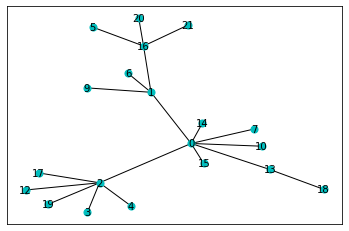

In [71]:
def CreateGraph(matrix):
    G = nx.Graph()
    n=len(matrix)
    #Adds egdes along with their weights to the graph 
    for i in range(n) :
        for j in range(n)[i:] :
            if matrix[i][j] > 0 :
                G.add_edge(i, j, length = matrix[i][j]) 
    return G

G = CreateGraph(distance_matrix)
T = nx.minimum_spanning_tree(G)
nx.draw_networkx(T, node_size=50, node_color='c', font_size=10)